In [2]:
# mini_progan.py
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.datasets as D, torchvision.utils as vutils, torch.nn.functional as F
import os

# -------------------------
# Small blocks
# -------------------------
class GBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1), nn.LeakyReLU(0.2, True),
        )
    def forward(self, x): return self.net(x)

class DBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, 1, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.LeakyReLU(0.2, True),
            nn.AvgPool2d(2),
        )
    def forward(self, x): return self.net(x)

# -------------------------
# Compact Generator / Discriminator
# -------------------------
class Generator(nn.Module):
    def __init__(self, z_dim=128, channels=[256,128,64,32]):
        super().__init__()
        self.z_dim = z_dim
        self.channels = channels
        self.fc = nn.Linear(z_dim, channels[0]*4*4)
        self.initial = nn.Sequential(
            nn.Conv2d(channels[0], channels[0], 3, 1, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(channels[0], channels[0], 3, 1, 1), nn.LeakyReLU(0.2, True),
        )
        self.blocks = nn.ModuleList([GBlock(channels[i], channels[i+1]) for i in range(len(channels)-1)])
        self.to_rgbs = nn.ModuleList([nn.Conv2d(ch, 3, 1) for ch in channels])

    def forward(self, z, alpha, step):
        b = z.size(0)
        x = self.fc(z).view(b, self.channels[0], 4, 4)
        x = self.initial(x)
        if step == 0:
            return torch.tanh(self.to_rgbs[0](x))
        # build up to step
        for i in range(step):
            x = self.blocks[i](x)
        img_new = self.to_rgbs[step](x)
        # compute previous-level rgb for fade (cheap second pass up to step-1)
        x_prev = self.fc(z).view(b, self.channels[0], 4, 4)
        x_prev = self.initial(x_prev)
        for i in range(step-1):
            x_prev = self.blocks[i](x_prev)
        img_prev = F.interpolate(self.to_rgbs[step-1](x_prev), scale_factor=2, mode='nearest')
        img = alpha*img_new + (1-alpha)*img_prev
        return torch.tanh(img)

class Discriminator(nn.Module):
    def __init__(self, channels=[256,128,64,32]):
        super().__init__()
        self.channels = channels
        # from_rgb aligned with channels (highest-res is last channel)
        self.from_rgbs = nn.ModuleList([nn.Conv2d(3, ch, 1) for ch in channels])
        self.blocks = nn.ModuleList([DBlock(channels[i+1], channels[i]) for i in range(len(channels)-1)][::-1])  # high->low order
        self.final = nn.Sequential(
            nn.Conv2d(channels[0], channels[0], 3, 1, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(channels[0], 1, 4)  # assumes final is 4x4
        )

    def forward(self, img, alpha, step):
        # step=0 => 4x4
        if step == 0:
            x = self.from_rgbs[0](img)
            return self.final(x).view(img.size(0), -1)
        # high-res path
        # Use from_rgbs corresponding to the current step's resolution (highest)
        x_high = self.from_rgbs[step](img)
        # apply first DBlock (which downsamples), it maps from channels[step] to channels[step-1]
        x_high = self.blocks[len(self.blocks) - step](x_high) # Corrected index
        # low-res path from downsampled image
        img_down = F.avg_pool2d(img, 2)
        # Use from_rgbs corresponding to the previous step's resolution
        x_low = self.from_rgbs[step-1](img_down)

        x = alpha * x_high + (1-alpha) * x_low
        # continue through remaining blocks
        # Iterate through blocks from step-1 down to 0
        for i in range(len(self.blocks) - step + 1, len(self.blocks)): # Corrected slice
             x = self.blocks[i](x)

        return self.final(x).view(img.size(0), -1)

# -------------------------
# Tiny training skeleton
# -------------------------
def get_loader(res, bs):
    tf = T.Compose([T.Resize(res), T.CenterCrop(res), T.ToTensor(), T.Normalize([0.5]*3,[0.5]*3)])
    ds = D.CIFAR10('./data', download=True, transform=tf)
    return DataLoader(ds, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True)

def train_simple(z_dim=128, max_res=32, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    # resolutions and channel schedule (short)
    res_list = [4,8,16,32]
    channels = [256,128,64,32][:len(res_list)]
    G = Generator(z_dim, channels).to(device)
    D = Discriminator(channels).to(device)
    opt_g = optim.Adam(G.parameters(), 2e-4, betas=(0.0,0.99))
    opt_d = optim.Adam(D.parameters(), 2e-4, betas=(0.0,0.99))
    loss = nn.BCEWithLogitsLoss()
    for stage, res in enumerate(res_list):
        step = stage  # 0 -> 4x4, 1 -> 8x8, ...
        bs = {4:64,8:64,16:32,32:16}[res]
        loader = get_loader(res, bs)
        data_iter = iter(loader)
        fade_iters, stab_iters = 300, 500
        # Fade-in
        for it in range(fade_iters):
            try: real = next(data_iter)[0].to(device)
            except: data_iter = iter(loader); real = next(data_iter)[0].to(device)
            b = real.size(0)
            alpha = it / max(1, fade_iters-1)
            z = torch.randn(b, z_dim, device=device)
            fake = G(z, alpha, step).detach()
            # D step
            opt_d.zero_grad()
            rlog = D(real, alpha, step); flog = D(fake, alpha, step)
            dloss = loss(rlog, torch.ones_like(rlog)) + loss(flog, torch.zeros_like(flog))
            dloss.backward(); opt_d.step()
            # G step
            opt_g.zero_grad()
            gen = G(z, alpha, step)
            gloss = loss(D(gen, alpha, step), torch.ones_like(rlog))
            gloss.backward(); opt_g.step()
            if it % 100 == 0: print(f"[{res}] fade {it}/{fade_iters} alpha={alpha:.3f} d={dloss.item():.3f} g={gloss.item():.3f}")
        # Stabilize
        for it in range(stab_iters):
            try: real = next(data_iter)[0].to(device)
            except: data_iter = iter(loader); real = next(data_iter)[0].to(device)
            b = real.size(0); alpha = 1.0
            z = torch.randn(b, z_dim, device=device)
            fake = G(z, alpha, step).detach()
            opt_d.zero_grad()
            rlog = D(real, alpha, step); flog = D(fake, alpha, step)
            dloss = loss(rlog, torch.ones_like(rlog)) + loss(flog, torch.zeros_like(flog))
            dloss.backward(); opt_d.step()
            opt_g.zero_grad()
            gen = G(z, alpha, step)
            gloss = loss(D(gen, alpha, step), torch.ones_like(rlog))
            gloss.backward(); opt_g.step()
            if it % 200 == 0: print(f"[{res}] stab {it}/{stab_iters} d={dloss.item():.3f} g={gloss.item():.3f}")
        # sample
        with torch.no_grad():
            z = torch.randn(16, z_dim, device=device)
            imgs = G(z, 1.0, step)
            os.makedirs('samples', exist_ok=True)
            vutils.save_image((imgs+1)/2, f'samples/sample_{res}.png', nrow=4)
            print("Saved", f'samples/sample_{res}.png')

if __name__ == '__main__':
    train_simple()

[4] fade 0/300 alpha=0.000 d=1.393 g=0.776
[4] fade 100/300 alpha=0.334 d=1.355 g=0.770
[4] fade 200/300 alpha=0.669 d=1.384 g=0.723
[4] stab 0/500 d=1.383 g=0.735
[4] stab 200/500 d=1.395 g=0.707
[4] stab 400/500 d=1.409 g=0.643
Saved samples/sample_4.png
[8] fade 0/300 alpha=0.000 d=1.393 g=0.678
[8] fade 100/300 alpha=0.334 d=1.381 g=0.707
[8] fade 200/300 alpha=0.669 d=1.393 g=0.744
[8] stab 0/500 d=1.371 g=0.721
[8] stab 200/500 d=1.364 g=0.716
[8] stab 400/500 d=1.383 g=0.721
Saved samples/sample_8.png
[16] fade 0/300 alpha=0.000 d=1.408 g=0.775
[16] fade 100/300 alpha=0.334 d=1.382 g=0.723
[16] fade 200/300 alpha=0.669 d=1.387 g=0.718
[16] stab 0/500 d=1.448 g=0.711
[16] stab 200/500 d=1.416 g=0.773
[16] stab 400/500 d=1.365 g=0.730
Saved samples/sample_16.png
[32] fade 0/300 alpha=0.000 d=1.384 g=0.738
[32] fade 100/300 alpha=0.334 d=1.383 g=0.709
[32] fade 200/300 alpha=0.669 d=1.406 g=0.699
[32] stab 0/500 d=1.376 g=0.707
[32] stab 200/500 d=1.374 g=0.773
[32] stab 400/500 d=

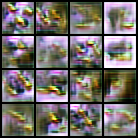

In [7]:
from IPython.display import Image, display
display(Image('samples/sample_32.png'))   # change name if needed



